# 注意力汇聚

## 1 导入相关库

In [1]:
import torch
from torch import nn
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

### 1.1 定义热度图函数

In [ ]:
def plot_hotmap(harvest, x_label = None, y_lable = None, hotmap_value = False, rotate_x_text = False, txt = False):
    # 生成图形对象 fig 和 子图对象 ax，使用约束布局避免重叠
    fig, ax = plt.subplots(constrained_layout=True)
    # 设置坐标轴比例
    ax.set_aspect(aspect=1.0)
    # 设置坐标轴范围，更多参数 https://www.wolai.com/matplotlib/9S3VvdWev3tNckFvKcMHKA
    im = ax.imshow(harvest, cmap="Reds")
    # # X轴 和 Y轴 上的标签文字
    # ax.set_xticks(np.arange(len(x_ax_text)), labels=x_ax_text)
    # ax.set_yticks(np.arange(len(y_ax_text)), labels=y_ax_text)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_lable)
    # 添加文字注释
    if txt == True:
        m, n = harvest.shape()
        if hotmap_value:
            for i in range(m):
                for j in range(n):
                    text = ax.text(j, i, harvest[i, j], ha="center", va="center", color="w")
    # 旋转X轴标签文字
    if rotate_x_text:
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # 添加颜色条
    cbar = fig.colorbar(im, ax=ax, shrink=0.92, aspect=15)
    # 设置颜色条标签
    cbar.set_label("attention value (unit)", fontweight="bold")
    # 保存图片
    # plt.savefig('./热度图.png', dpi=300)
    # 显示图片
    plt.show()

## 1.2 生成数据集

In [31]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
y_train.shape

torch.Size([50])

## 1.3 画图

In [32]:
def plt_map(x, y, x_label, y_label, legend, x_lim, y_lim, multi = True):
    
    # 生成图形对象 fig 和 子图对象 ax，使用约束布局避免重叠
    fig, ax = plt.subplots(constrained_layout=True)
    
    _ = ax.scatter(x_train, y_train, alpha=0.5)
    # 两次调用坐标系对象 ax 的 plot 方法，绘制两条折线
    # 参数详见 https://www.wolai.com/matplotlib/4GXojnYSjgrrezCPMMy4on
    if multi == True:
        for i in range(len(y)):
            _ = ax.plot(x, y[i], label=legend[i])
    else:
        _ = ax.plot(x, y, label=legend)

    # 设置 x 轴和 y 轴的刻度
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

    # 设置 x 轴和 y 轴的轴标签，加粗显示
    ax.set_xlabel(x_label, fontweight="bold")
    ax.set_ylabel(y_label, fontweight="bold")

    # 添加图例
    _ = ax.legend()

    # 保存图片
    # plt.savefig('./简单折线图.png', dpi=300)

    # 显示图形
    plt.show()

def plot_all_map(y_hat):
    plt_map(x_test, [y_truth, y_hat], "x", "y", ["truth", "predict"], [0, 5], [-1, 5])

## 1.4 绘制动图

In [33]:
def plot_image(i, train_loss_his, num_epochs):
    plt.ion()
    plt.cla()
    fig, ax1 = plt.subplots(constrained_layout=True)
    ax1.grid(ls='-.')
    ax1.set_xlim((0, num_epochs))
    #ax1.set_ylim(0, 1.6)
    ax1.plot(range(i + 1), train_loss_his, label='train_loss')
    ax1.legend()
    display.clear_output(wait=True)
    # plt.pause(0.001)
    plt.ioff()
    plt.show()

# 2 各种汇聚

## 2.1 平均汇聚
$$
f(x) = \frac{1}{n} \sum_{i=1}^{n} y_i
$$
其中x是输入值，yi是训练集y值。

In [2]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_all_map(y_hat)

NameError: name 'y_train' is not defined

## 2.2 非参数注意力汇聚
$$
f(x) = \sum_{i=1}^n \frac{K(x-x_i)y_i}{\sum_{j=1}^n K(x-x_j)} \tag{1}
$$
其中x是查询，（xi，yi）是键值对，将查询x和键（xi，yi）之间的关系建模为 $\alpha(x, x_i)$ 注意力权重（attention weight）。K是一个核函数，重写公式1，会得到一个更加通用的注意力汇聚（attention pooling）公式：
$$
f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i \tag{2}
$$
我们用一个高斯核（Gaussian kernel）来代表K核。
$$
K(u) = \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{u^2}{2}\right) \tag{3}
$$
将3带入到1中得：
$$
\begin{align*}
f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\
&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\
&= \sum_{i=1}^n \text{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i
\end{align*} \tag{4}
$$
其中x是输入值，xi是训练集x值，yi是训练集y值。

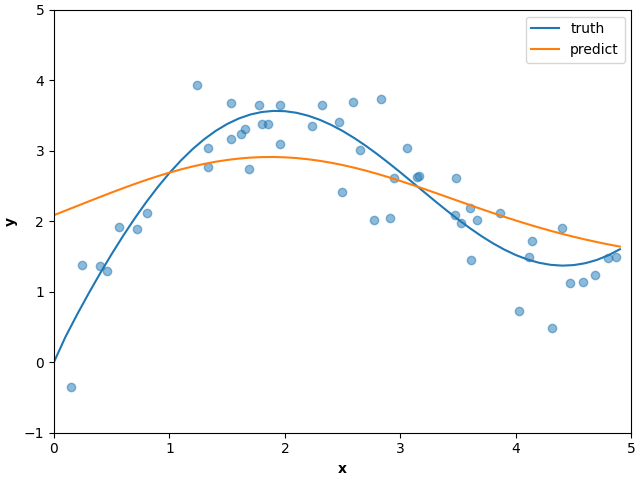

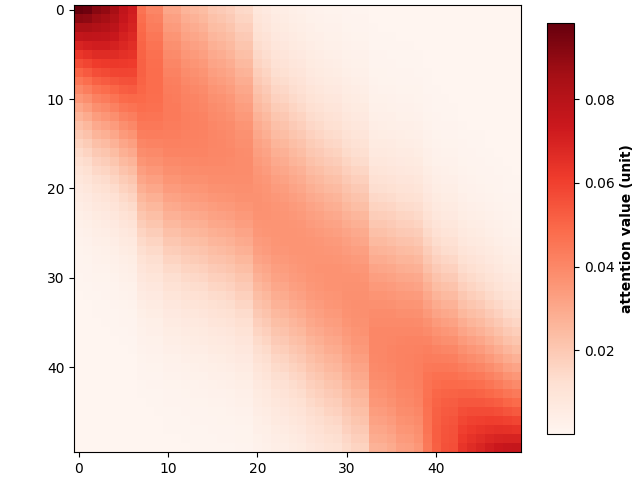

In [35]:
x_input = x_test.repeat_interleave(n_train).reshape((-1, n_train))
attention_weights = nn.functional.softmax(-(x_input - x_train)**2 / 2, dim=1)
y_hat = torch.matmul(attention_weights, y_train)
plot_all_map(y_hat)
plot_hotmap(attention_weights)

## 2.3 带参数注意力汇聚
不用批量不收敛，所以改成书中用批量了。
$$
\begin{align*}
f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\
&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}\left((x - x_i)w\right)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}\left((x - x_j)w\right)^2\right)} y_i \\
&= \sum_{i=1}^n \textrm{softmax}\left(-\frac{1}{2}\left((x - x_i)w\right)^2\right) y_i.
\end{align*}
$$
其中w为可学习参数，其不是一个矩阵，就是单独的一个数。

### 2.3.1 定义类

In [36]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand(1, requires_grad = True))
        print(self.w)

    def forward(self, queries, keys, values):
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-(((queries - keys)*self.w)**2) / 2, dim=1)
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

In [37]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

In [38]:
def train_net(epochs, alpha, device):

    train_loss_his = []

    net = NWKernelRegression()
    loss = nn.MSELoss(reduction="none")
    trainer = torch.optim.SGD(net.parameters(), lr = alpha)
    net.to(device)

    net.train()
    for i in range(epochs):
        trainer.zero_grad()
        train_hat = net(x_train, keys, values)
        train_loss = loss(train_hat, y_train)
        train_loss.sum().backward()
        trainer.step()
        with torch.no_grad():
            train_loss_his.append(train_loss.sum())
            plot_image(i, train_loss_his, epochs)
    
    return net 

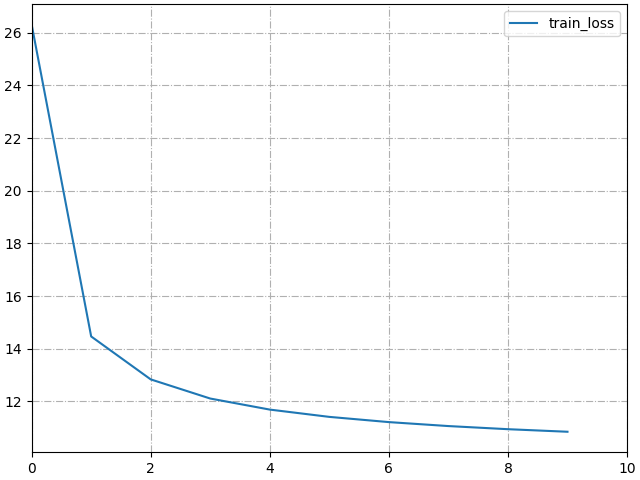

In [41]:
device = torch.device("cpu")
num_epochs, alpha = 10, 0.02
net = train_net(num_epochs, alpha, device)

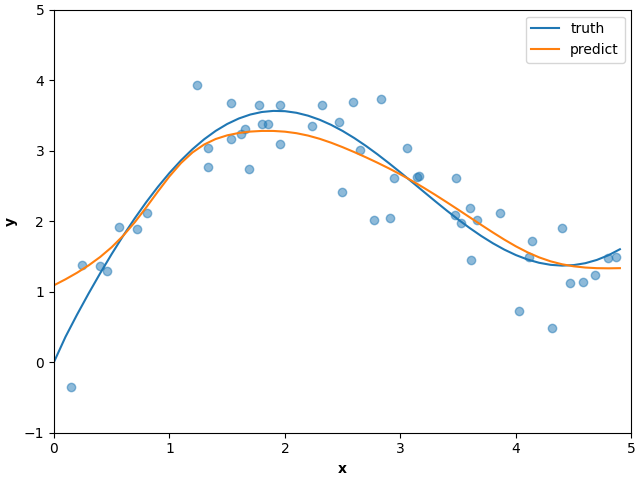

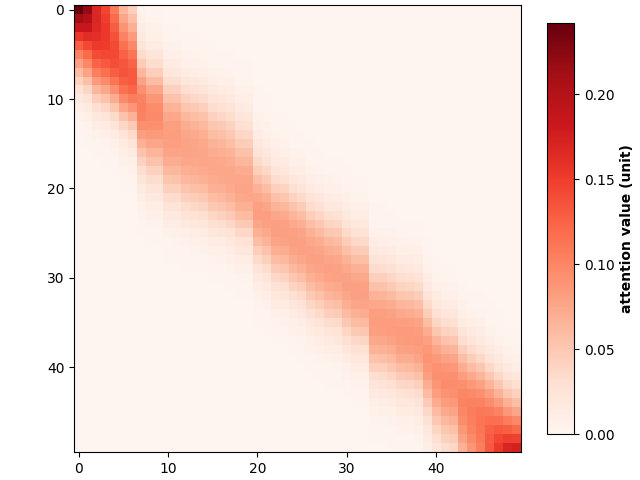

In [42]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_all_map(y_hat)
plot_hotmap(net.attention_weights.detach().numpy())